In [ ]:
import tensorflow as tf
from keras.models import Sequential, save_model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from google.colab import drive
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import array_to_img, img_to_array

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Pobranie danych

In [ ]:
data_path = '/content/drive/MyDrive/german_sign_classification/data/'
label_path = '/content/drive/MyDrive/german_sign_classification/labels.csv'

In [ ]:
class_list = os.listdir(data_path)
len_class_list = len(class_list)

In [ ]:
def colect_data(data_path):
    images = []
    classes = []
    class_list = os.listdir(data_path)

    print(f"Total Classes Detected: {len_class_list}")
    print("Importing Classes.....")

    for class_num in range(len_class_list):
        pic_list = os.listdir(data_path  + f'/class_ ({class_num})')
        for img in pic_list:
            cur_img = cv2.imread(data_path + f'/class_ ({class_num})' + "/" + img)
            if cur_img is None:
                print('img is none')
            cur_img = cv2.resize(cur_img, (28, 28))
            images.append(cur_img)
            classes.append(class_num)
        print(class_num, end=" ")
    print(" ")
    images = np.array(images)
    classes = np.array(classes)
    return images, classes

In [ ]:
images, classes = colect_data(data_path)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [ ]:
print(images.shape)
print(classes.shape)

(26641, 28, 28, 3)
(26641,)


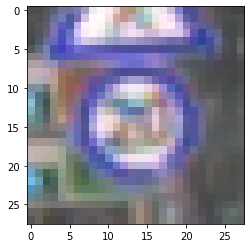

In [ ]:
plt.imshow(images[2])

## Podział danych na zbiory

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print('Shapes')
print('===========================')
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(" ")
print(f"X_validation: {X_validation.shape}")
print(f"y_validation: {y_validation.shape}")
print(" ")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print('===========================')

Shapes
X_train: (17049, 28, 28, 3)
y_train: (17049,)
 
X_validation: (4263, 28, 28, 3)
y_validation: (4263,)
 
X_test: (5329, 28, 28, 3)
y_test: (5329,)


### Klasy 

In [ ]:
labels = pd.read_csv(label_path)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  43 non-null     int64 
 1   Name     43 non-null     object
dtypes: int64(1), object(1)
memory usage: 816.0+ bytes


In [ ]:
labels.sample(4)

,ClassId,Name
12,12,Priority road
37,37,Go straight or left
34,34,Turn left ahead
4,4,Speed limit (70km/h)


## Rozkład poszczególnych klas 

In [ ]:
def show_distribution(labels, X_train, y_train):
    class_list = os.listdir(data_path)
    num_of_samples = []
    for idx, _ in labels.iterrows():
        x_selected = X_train[np.where(y_train == idx)]
        num_of_samples.append(len(x_selected))
        
    plt.figure(figsize=(12, 4))
    plt.bar(range(0, len(class_list)), num_of_samples)
    plt.title("Distribution of the training dataset")
    plt.xlabel("Class number")
    plt.ylabel("Number of images")
    plt.grid()
    plt.show()

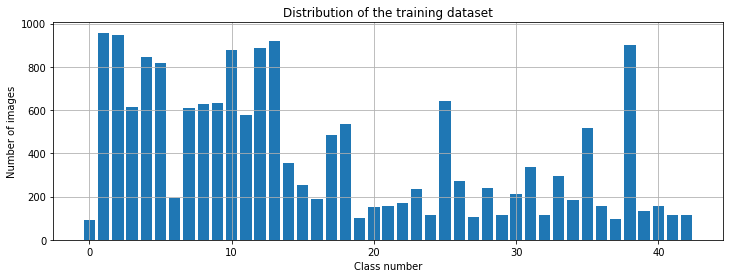

In [ ]:
show_distribution(labels, X_train, y_train)

In [ ]:
# Po dodaniu obraów za pomocą ImageDataGenerator, model działał gorzej 
# Sposób wykonania na końcu notatnika 

### Preprocessing danych

In [ ]:
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.equalizeHist(img) # It is a method that improves the contrast in an image  
    img = img / 255
    return img

In [ ]:
X_train = np.array(list(map(preprocessing, X_train))) 
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

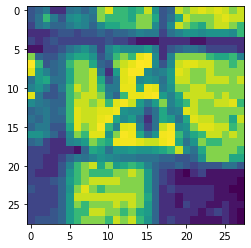

In [ ]:
plt.imshow(X_train[0])

### Dodanie kolejnego wymiaru 

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
y_train = to_categorical(y_train, len_class_list)
y_validation = to_categorical(y_validation, len_class_list)
y_test = to_categorical(y_test, len_class_list)

In [ ]:
print('Shapes')
print('===========================')
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(" ")
print(f"X_validation: {X_validation.shape}")
print(f"y_validation: {y_validation.shape}")
print(" ")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print('===========================')

Shapes
X_train: (17049, 28, 28, 1)
y_train: (17049, 43)
 
X_validation: (4263, 28, 28, 1)
y_validation: (4263, 43)
 
X_test: (5329, 28, 28, 1)
y_test: (5329, 43)


### Budowa modelu 

In [ ]:
EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

In [ ]:
def CNN_model_1():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len_class_list, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [ ]:
model_1 = CNN_model_1()
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                      

In [ ]:
history = model_1.fit(X_train, y_train,
              batch_size= 16,
              epochs= 30,
              validation_data= (X_test, y_test),
              callbacks=[EarlyStop],
              shuffle=True)

Epoch 1/30
1066/1066 [==============================] - 19s 6ms/step - loss: 1.0920 - accuracy: 0.6985 - val_loss: 0.1871 - val_accuracy: 0.9482
Epoch 2/30
1066/1066 [==============================] - 7s 6ms/step - loss: 0.1669 - accuracy: 0.9493 - val_loss: 0.1050 - val_accuracy: 0.9621
Epoch 3/30
1066/1066 [==============================] - 8s 7ms/step - loss: 0.1108 - accuracy: 0.9649 - val_loss: 0.0747 - val_accuracy: 0.9777
Epoch 4/30
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0744 - accuracy: 0.9769 - val_loss: 0.0487 - val_accuracy: 0.9857
Epoch 5/30
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0638 - accuracy: 0.9796 - val_loss: 0.0627 - val_accuracy: 0.9807
Epoch 6/30
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0576 - accuracy: 0.9812 - val_loss: 0.0595 - val_accuracy: 0.9837
Epoch 7/30
1066/1066 [==============================] - 10s 9ms/step - loss: 0.0499 - accuracy: 0.9837 - val_loss: 0.0504 - val_accurac

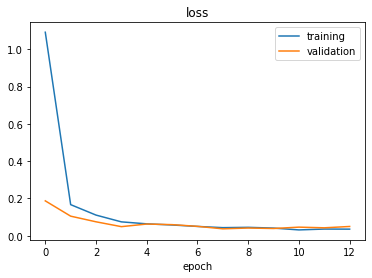

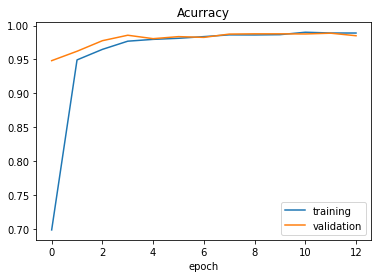

Test Score: 0.04967725649476051
Test Accuracy: 0.9849877953529358


In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model_1.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [ ]:
tf.keras.models.save_model(model_1, "/content/drive/MyDrive/german_sign_classification/CNN_model_1_main_colab.hdf5")

In [ ]:
def CNN_model_2():
    model = Sequential()
    model.add(Conv2D(32, (1, 1), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(392, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len_class_list, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [ ]:
model_2 = CNN_model_2()
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        64        
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        36928     
                                                      

In [ ]:
history = model_2.fit(X_train, y_train,
              batch_size= 16,
              epochs= 50,
              validation_data= (X_test, y_test),
              callbacks=[EarlyStop],
              shuffle=True)

Epoch 1/50
1066/1066 [==============================] - 7s 6ms/step - loss: 2.5677 - accuracy: 0.4027 - val_loss: 1.0410 - val_accuracy: 0.8270
Epoch 2/50
1066/1066 [==============================] - 6s 5ms/step - loss: 1.1701 - accuracy: 0.7761 - val_loss: 0.7051 - val_accuracy: 0.9306
Epoch 3/50
1066/1066 [==============================] - 6s 5ms/step - loss: 0.9086 - accuracy: 0.8537 - val_loss: 0.5986 - val_accuracy: 0.9563
Epoch 4/50
1066/1066 [==============================] - 6s 6ms/step - loss: 0.8117 - accuracy: 0.8805 - val_loss: 0.5355 - val_accuracy: 0.9711
Epoch 5/50
1066/1066 [==============================] - 6s 6ms/step - loss: 0.7248 - accuracy: 0.9015 - val_loss: 0.4990 - val_accuracy: 0.9730
Epoch 6/50
1066/1066 [==============================] - 6s 6ms/step - loss: 0.7011 - accuracy: 0.9082 - val_loss: 0.4828 - val_accuracy: 0.9749
Epoch 7/50
1066/1066 [==============================] - 6s 5ms/step - loss: 0.6717 - accuracy: 0.9170 - val_loss: 0.4903 - val_accuracy:

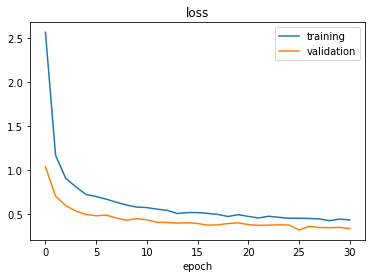

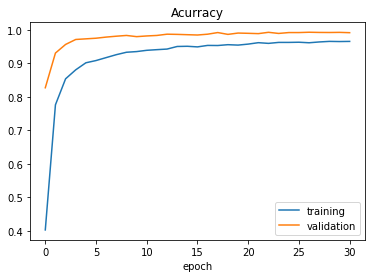

Test Score: 0.33763718605041504
Test Accuracy: 0.9913679957389832


In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model_2.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

### Zapisanie modelu 

In [ ]:
tf.keras.models.save_model(model_2, "/content/drive/MyDrive/german_sign_classification/CNN_model_main_2_colab.hdf5")

==============================================================================================================

### ImageDataGenerator

In [ ]:
num_of_samples = []
for idx, _ in labels.iterrows():
    print(idx)
    #x_selected = X_train[np.where(y_train == idx)]
    #num_of_samples.append(len(x_selected))

    class_list = os.listdir(data_path)
    num_of_samples = []
    for idx, _ in labels.iterrows():
        x_selected = X_train[np.where(y_train == idx)]
        num_of_samples.append(len(x_selected))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [ ]:
MAX_NUM_OF_SAMPLES = max(num_of_samples)
MAX_NUM_OF_SAMPLES

In [ ]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [ ]:
test_images = []
size_of_labels = []

for i in range(0, len(class_list)):
    pic_list = os.listdir(data_path  + f'/class_ ({i})') # 0, 1, 2, 3 ...
    size_of_labels.append(len(pic_list))
    for idx in pic_list:
        cur_img = cv2.imread(data_path + f'/class_ ({i})' + "/" + idx)
        test_images.append(cur_img)
        break

In [ ]:
dir_path = r'C:\Users\26609\Desktop\german_sign\Training'
num_of_samples = []
for idx, pic in enumerate(test_images):
    img = img_to_array(pic)  # convert image to numpy arry
    img = img.reshape((1,) + img.shape)  # reshape imag
    for batch in datagen.flow(img, save_to_dir= dir_path + f'/class_ ({idx})', save_prefix='test_image', save_format='ppm'):  # this loops runs forever until we break, saving images to current directory with specified prefix
        size_of_labels[idx] += 1
        if size_of_labels[idx] >= MAX_NUM_OF_SAMPLES: 
            break

#### Rozkład danych po wykonaniu

![obraz_2022-06-24_104245104.png](attachment:obraz_2022-06-24_104245104.png)